In [2]:
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import GaussianBlur, v2, functional
import cv2
import matplotlib.pyplot as plt

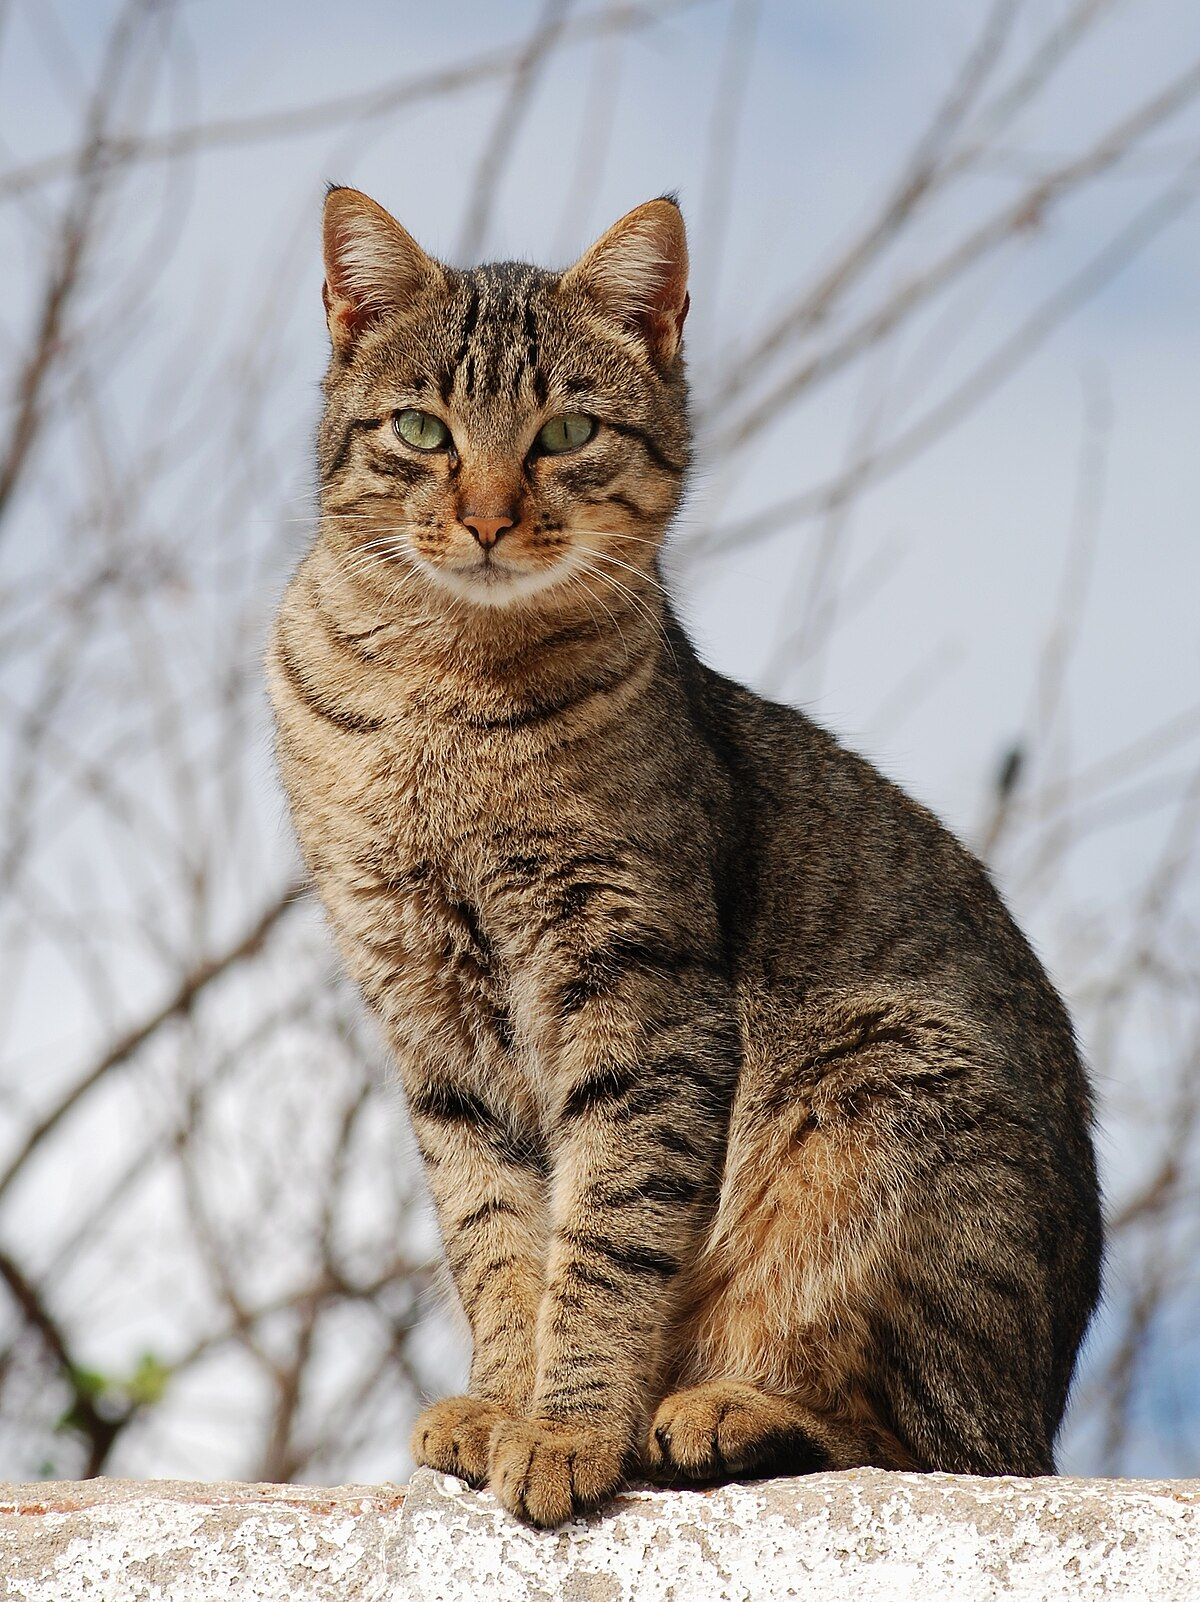

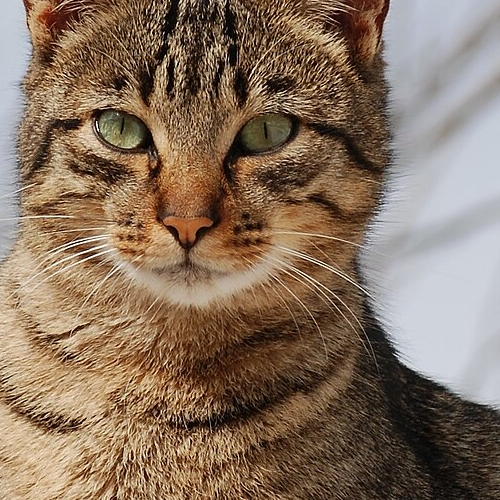

In [7]:
img=Image.open("./test_img/cat.JPEG")
display(img)
observation=v2.functional.crop(img,300,300,500,500) #top,left,height,width
display(observation)
#observation=functional.pil_to_tensor(observation)

## Numpy version

500 500
(500, 500, 3)


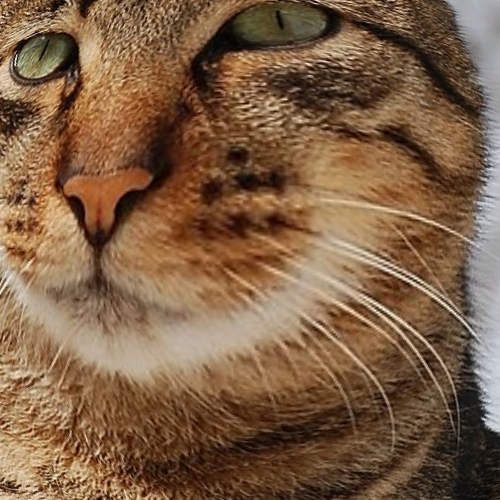

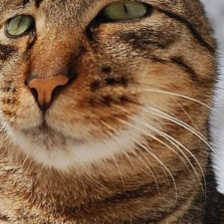

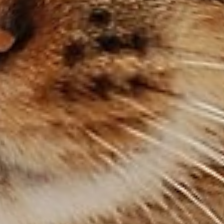

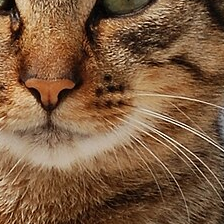

In [8]:


def nonlinear_amplify(image, alpha=2.0, beta=0.5):
    # 获取图像的高度和宽度
    height, width = image.shape[:2]
    print(height,width)

    # 计算图像中心
    center_x, center_y = width // 2, height // 2

    # 创建网格
    x, y = np.meshgrid(np.arange(width), np.arange(height))

    # 计算到中心的距离
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # 计算放大因子
    factors = 0.2 + alpha * np.exp(-beta * distances)

    # 计算新的像素位置
    new_x = center_x + (x - center_x) * factors
    new_y = center_y + (y - center_y) * factors

    # 使用双线性插值
    map_x = new_x.astype(np.float32)
    map_y = new_y.astype(np.float32)

    # 重新映射像素值
    amplified_image = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    print(amplified_image.shape)

    return amplified_image,map_x,map_y

# 读取图像
image = np.asarray(observation)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 进行中心位置的非线性放大
#amplified_image,map_x,map_y = nonlinear_amplify(image, alpha=2.5, beta=0.005)

amplified_image,map_x,map_y = nonlinear_amplify(image, alpha=0.1, beta=-0.005)

# 显示原始图像和
display(Image.fromarray(amplified_image))
display(functional.resize(Image.fromarray(amplified_image), 224))
display(functional.center_crop(Image.fromarray(amplified_image), output_size=(224,224)))
display(functional.center_crop(observation, output_size=224))


## torch implementation

(3, 500, 500)
(500, 500)
[0.54903779 0.54729697 0.54556483 0.54384133 0.54212643 0.54042008
 0.53872224 0.53703287 0.53535193 0.53367937 0.53201515 0.53035923
 0.52871157 0.52707213 0.52544087 0.52381774 0.52220271 0.52059573
 0.51899677 0.51740578 0.51582272 0.51424757 0.51268026 0.51112078
 0.50956907 0.50802511 0.50648884 0.50496024 0.50343926 0.50192586
 0.50042002 0.49892168 0.49743082 0.49594739 0.49447136 0.4930027
 0.49154136 0.4900873  0.4886405  0.48720092 0.48576851 0.48434325
 0.4829251  0.48151402 0.48010998 0.47871294 0.47732287 0.47593974
 0.4745635  0.47319413 0.47183158 0.47047583 0.46912685 0.46778459
 0.46644902 0.46512012 0.46379785 0.46248217 0.46117305 0.45987046
 0.45857437 0.45728474 0.45600155 0.45472475 0.45345432 0.45219023
 0.45093245 0.44968094 0.44843567 0.44719661 0.44596373 0.444737
 0.44351639 0.44230186 0.4410934  0.43989096 0.43869451 0.43750404
 0.4363195  0.43514088 0.43396813 0.43280123 0.43164014 0.43048486
 0.42933533 0.42819153 0.42705344 0.4259

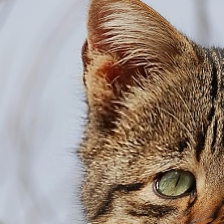

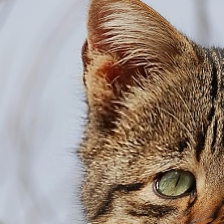

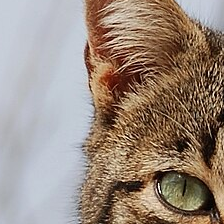

In [5]:
import torch.nn.functional as F

def foveate_transform(image, output_size, alpha=2.0, beta=0.5):
    # Input [C, H, W]
    assert image.shape[0] == 3
    height, width = image.shape[1:]

    center_x, center_y = width // 2, height // 2

    # Create meshgrid and calculate distances in a vectorized way
    y, x = np.ogrid[:height, :width]
    distances = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

    # Calculate scaling factors
    factors = 0.2 + alpha * np.exp(-beta * distances)
    print(factors.shape)
    print(factors[251][:])
    # Apply transformation in a vectorized way
    new_x = center_x + (x - center_x) * factors
    new_y = center_y + (y - center_y) * factors

    # Normalize coordinates to the range [-1, 1] for grid_sample
    new_x = (new_x / (width - 1)) * 2 - 1
    new_y = (new_y / (height - 1)) * 2 - 1

    # Stack and reshape to form a grid of shape [1, H, W, 2]
    grid_ = np.stack((new_x, new_y), axis=-1)
    print(grid_.shape)
    print((grid_[250,:,:]+1)/2*500)
    grid = torch.tensor(grid_, dtype=torch.float32).unsqueeze(0)
    
    # Convert image to tensor and add batch dimension
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # Apply grid_sample
    trans_image = F.grid_sample(image, grid, mode='bilinear', align_corners=True)

    # Resize the image to the output size -> inverse 500/224*coord -> -250,-250 -> /factor -> +250,+250
    trans_image = F.interpolate(trans_image, size=(output_size, output_size), mode='bilinear', align_corners=True)

    # Remove batch dimension and convert to [C, H, W]
    trans_image = trans_image.squeeze(0)

    return trans_image, grid_

image = np.asarray(observation).transpose(2,0,1)
print(image.shape)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

amplified_image, grid = foveate_transform(image, output_size=224, alpha=0.1, beta=-0.005)
amplified_image=amplified_image.to(torch.uint8)

# 显示原始图像和
print(amplified_image.shape)

display(functional.to_pil_image(amplified_image))
#display(functional.to_pil_image(functional.resize(amplified_image, 224)))
display(functional.to_pil_image(functional.center_crop(amplified_image, output_size=(224,224))))
display(functional.center_crop(observation, output_size=224))


In [6]:
# Assume 'matrix' is your 500x500x2 tensor
matrix = torch.rand(500, 500, 2)  # Example matrix with random values

# The batched target vectors (16, 2)
target_vectors = torch.rand(16, 2)  # Repl

expanded_targets = target_vectors[:, None, None, :]  # Shape: (16, 1, 1, 2)

# Calculate the Euclidean distance
distances = torch.sqrt(torch.sum((matrix - expanded_targets) ** 2, dim=-1))  # Resulting shape: (16, 500, 500)

# Find the indices of the minimum distance for each batch
min_indices = torch.argmin(distances.view(16, -1), dim=1)  # Shape: (16,)

# Convert the flattened indices back to 2D coordinates
row_indices, col_indices = torch.div(min_indices, 500, rounding_mode='floor'), min_indices % 500


In [69]:
grid=torch.rand((4,4,2))
print(grid)
torch.flip(grid,dims=[-1])

tensor([[[0.0149, 0.6091],
         [0.3880, 0.2255],
         [0.3145, 0.0050],
         [0.0130, 0.4751]],

        [[0.1499, 0.0587],
         [0.1389, 0.5598],
         [0.7794, 0.8693],
         [0.2480, 0.7942]],

        [[0.0782, 0.8888],
         [0.6953, 0.1635],
         [0.4074, 0.2631],
         [0.4403, 0.6947]],

        [[0.0032, 0.2817],
         [0.6064, 0.6521],
         [0.1027, 0.4508],
         [0.0705, 0.7653]]])


tensor([[[0.6091, 0.0149],
         [0.2255, 0.3880],
         [0.0050, 0.3145],
         [0.4751, 0.0130]],

        [[0.0587, 0.1499],
         [0.5598, 0.1389],
         [0.8693, 0.7794],
         [0.7942, 0.2480]],

        [[0.8888, 0.0782],
         [0.1635, 0.6953],
         [0.2631, 0.4074],
         [0.6947, 0.4403]],

        [[0.2817, 0.0032],
         [0.6521, 0.6064],
         [0.4508, 0.1027],
         [0.7653, 0.0705]]])